In [183]:
import nest
import numpy
import matplotlib.pyplot as plt

import nest
import numpy

nest.ResetKernel()

# Set simulation kernel
nest.SetKernelStatus({
  "local_num_threads": 1,
  "resolution": 0.1,
  "rng_seed": 1
})

# Create nodes
n1 = nest.Create("iaf_psc_alpha", 300, params={
  "C_m": 30,
  "E_L": -70,
  "V_reset": -70,
  "V_th": -60,
  "t_ref": 2,
  "tau_m": 20,
  "tau_syn_ex": 1,
  "tau_syn_in": 10,
})
n2 = nest.Create("iaf_psc_alpha", 500, params={
  "C_m": 30,
  "E_L": -70,
  "V_reset": -70,
  "V_th": -60,
  "t_ref": 2,
  "tau_m": 20,
  "tau_syn_ex": 1,
  "tau_syn_in": 10,
})
pg1 = nest.Create("poisson_generator", 1, params={
  "rate": 800,
})
sr1 = nest.Create("spike_recorder", 1, params={
  "start": 0,
  "stop": 1000,
})
sr2 = nest.Create("spike_recorder", 1, params={
  "start": 0,
  "stop": 1000,
})
dc1 = nest.Create("dc_generator", 1, params={
  "amplitude": -180,
  "start": 800,
  "stop": 950,
})
pg2 = nest.Create("poisson_generator", 1, params={
  "rate": 800,
  "start": 650,
  "stop": 950,
})

# Connect nodes
nest.Connect(n1, n1, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 50,
}, syn_spec={ 
  "weight": 50,
  "delay": 2,
})
nest.Connect(n2, n2, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 30,
}, syn_spec={ 
  "weight": -5,
  "delay": 2,
})
nest.Connect(n1, n2, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 50,
}, syn_spec={ 
  "weight": 30,
  "delay": 5,
})
nest.Connect(n2, n1, conn_spec={
  "rule": "fixed_indegree",
  "indegree": 30,
}, syn_spec={ 
  "weight": -15,
  "delay": 5,
})
nest.Connect(pg1, n2, syn_spec={ 
  "weight": 40,
})
nest.Connect(n1, sr1)
nest.Connect(n2, sr2)
nest.Connect(dc1, n1)
nest.Connect(pg1, n1, syn_spec={ 
  "weight": 65,
})
nest.Connect(pg2, n2, syn_spec={ 
  "weight": -5,
})

# Tag annotations
nest.userdict.clear()
nest.userdict["STN -excitatory"] = n1
nest.userdict["GPe -inhibitory"] = n2

# Run simulation
nest.Simulate(1000)

response = {
  "events": [sr1.events, sr2.events, ]
}

  
#########################################################
events_STN = sr1.events
events_GPe = sr2.events



Jan 29 02:59:29 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jan 29 02:59:30 NodeManager::prepare_nodes [Info]: 
    Preparing 805 nodes for simulation.

Jan 29 02:59:30 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 805
    Simulation time (ms): 1000
    Number of OpenMP threads: 1
    Number of MPI processes: 1

Jan 29 02:59:30 SimulationManager::run [Info]: 
    Simulation finished.


In [17]:
events_STN

{'senders': array([ 14, 141, 229, ...,  87,  67, 297]),
 'times': array([  2.8,   3. ,   2.8, ..., 583. , 587.9, 587.3])}

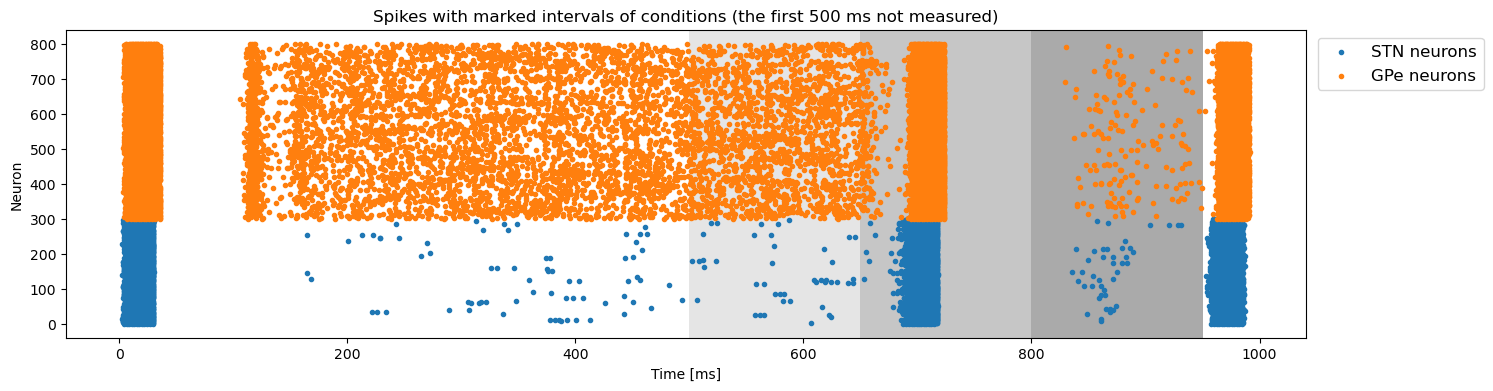

In [214]:
%matplotlib inline
import numpy as np

plt.figure(figsize=(16,4))
plt.axvspan(500, 950, facecolor='gray', alpha=0.2)
plt.axvspan(650, 950, facecolor='gray', alpha=0.3)
plt.axvspan(800, 950, facecolor='gray', alpha=0.4)
scatter_STN = plt.scatter(events_STN["times"], events_STN["senders"], marker=".")
scatter_GPe = plt.scatter(events_GPe["times"], events_GPe["senders"], marker=".")
plt.legend((scatter_STN, scatter_GPe),
           ('STN neurons', 'GPe neurons'),
           scatterpoints=1,
           ncol=1,
           fontsize=12,
          bbox_to_anchor=(1.15, 1))

plt.title("Spikes with marked intervals of conditions (the first 500 ms not measured)")
plt.xlabel("Time [ms]")
plt.ylabel("Neuron")


#ax.axhspan(4, 9, facecolor='yellow', alpha=0.5)
#ax.axhspan(9, 12, facecolor='red', alpha=0.5)
plt.plot()
plt.savefig("Nest_1.jpg")

In [204]:
def meanFR(events, start, end):
    return np.sum((events["times"] > start) & (events["times"] < end)) / (end - start)

binSize = 10
totalStart = 0
totalEnd = 1000
meanFR_STN = np.array([meanFR(events_STN, start, start + binSize) for start in range(totalStart, totalEnd)])
meanFR_GPe = np.array([meanFR(events_GPe, start, start + binSize) for start in range(totalStart, totalEnd)])
#print(meanFR_STN)

/tmp/ipykernel_455/1553100511.py:12: UserWarning:Data has no positive values, and therefore cannot be log-scaled.


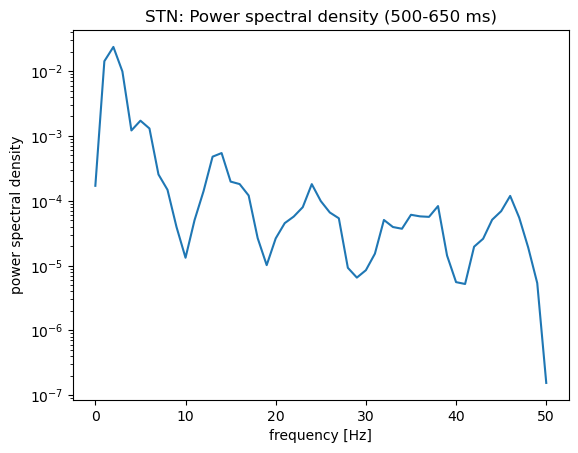

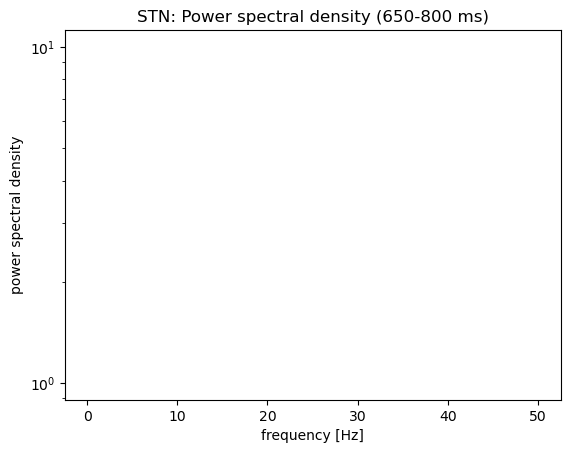

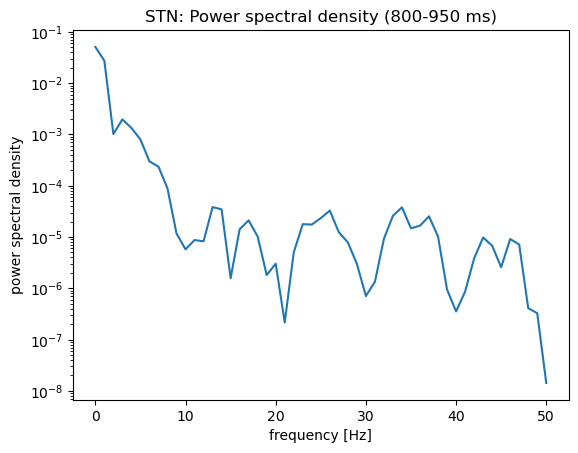

In [166]:
from scipy import signal
# STN: interval 500 - 1000 ms

intervals = [500, 650, 800, 950]
for start, end in zip(intervals, intervals[1:]):
    freq_STN, ps_dens_STN = signal.welch(meanFR_STN[start:end], 100, nperseg=100)
    plt.figure()
    plt.semilogy(freq_STN, ps_dens_STN)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('power spectral density')
    plt.title(f'STN: Power spectral density ({start}-{end} ms)')
    plt.savefig(f'STN_Welch_{start}_{end}.jpg')


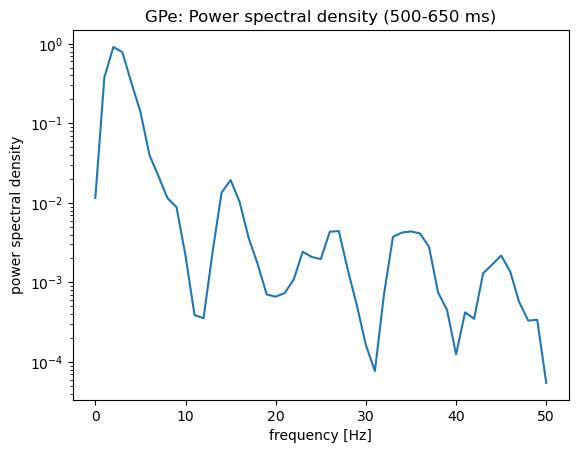

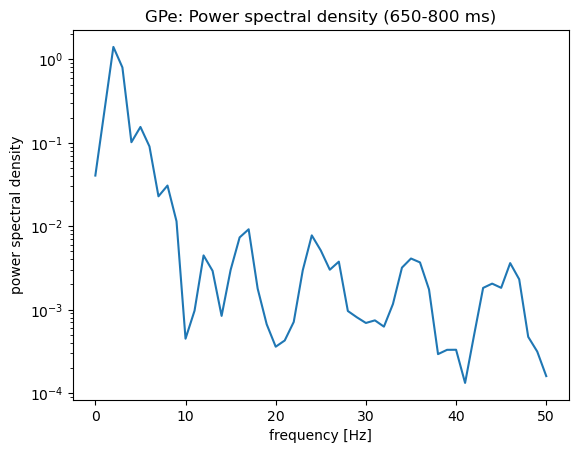

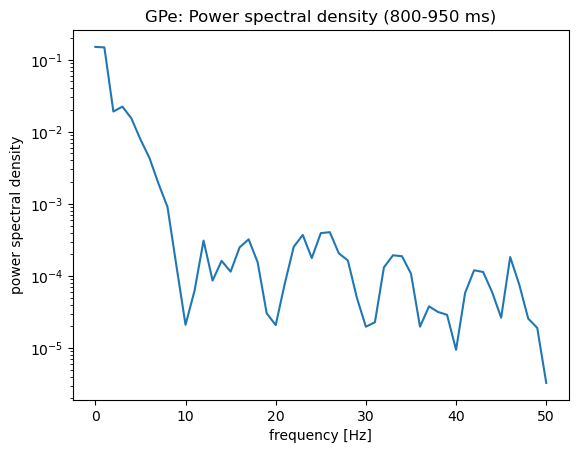

In [167]:
# GPe: interval 500 - 1000
for start, end in zip(intervals, intervals[1:]):
    freq_GPe, ps_dens_GPe = signal.welch(meanFR_GPe[start:end], 100, nperseg=100)
    plt.figure()
    plt.semilogy(freq_GPe, ps_dens_GPe)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('power spectral density')
    plt.title(f'GPe: Power spectral density ({start}-{end} ms)')
    plt.savefig(f'GPe_Welch_{start}_{end}.jpg')


-9.473903143468003e-17
1.0
0.0
1.0


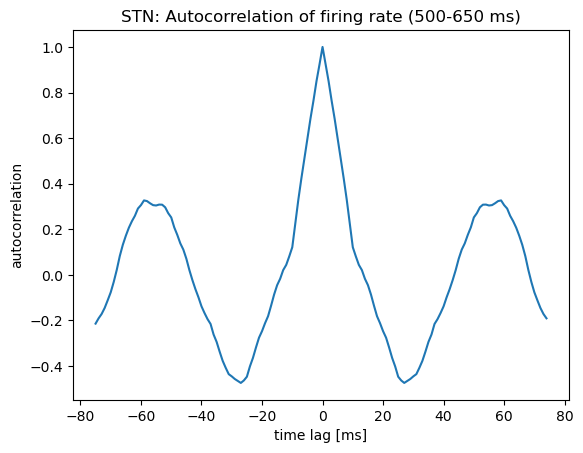

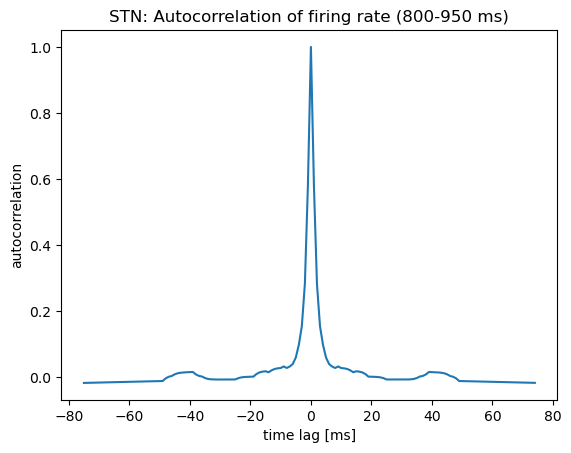

In [170]:
def norm_autocorrelation(fr):
    norm_fr = (fr - np.mean(fr))/np.std(fr)
    print(np.mean(norm_fr)) # ~ 0
    print(np.std(norm_fr))  # ~ 1
    autocorrelation = np.correlate(norm_fr, norm_fr, mode='same')
    return autocorrelation/np.max(autocorrelation)

for start, end in zip(intervals, intervals[1:]):
    if np.max(meanFR_STN[start:end]) == 0:
        continue
    autocorrelation_STN = norm_autocorrelation(meanFR_STN[start:end])
    plt.figure()
    plt.title(f'STN: Autocorrelation of firing rate ({start}-{end} ms)')
    plt.xlabel('time lag [ms]')
    plt.ylabel('autocorrelation')
    plt.plot(np.arange(-(end-start)/2, (end-start)/2), autocorrelation_STN)
    plt.savefig(f'STN_Autocorrelation_{start}_{end}.jpg')
